In [1]:
%run ../_preamble.ipynb
from _work.src.modules import AutoEncoder, train_model, plot_metrics, plot_tensor, eval_model, get_distances, get_closest_item
from _work.src.modules.replay import get_attractors, iterate
from _work.src.modules.utils import save_metrics, load_metrics
from _work.src.data import small_dataloader as dataloader
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch

palette = {
    'Oak': '#B0E65A',
    'Pine': '#75993C',
    'Daisy': '#FEB756',
    'Rose': '#E6634E',
    'Salmon': '#9194E3',
    'Sunfish': '#8BCBD9',
    'Canary': '#FFD92F',
    'Robin': '#FF8C9A',
}

def generate_patterns(model, n_runs=1, n_steps=10, take_last=1, mean=0, stdev=1, multiplier=1):
    assert take_last <= n_steps

    states, _ = iterate(model, runs=n_runs, steps=n_steps, mean=mean, stdev=stdev, multiplier=multiplier)
    states = torch.vstack(tuple(states[:, -take_last:, :]))

    return states # n_runs * take_last

def create_dataloaders(states, n_epochs):
    class ReplayDataset(Dataset):
        def __init__(self, data):
            super().__init__()
            self.data = data
        
        def __len__(self):
            return len(self.data)
        
        def __getitem__(self, i):
            return {
                'y': self.data[i],
            }

    dataloaders = []
    for _ in range(n_epochs):
        indices = np.random.choice(list(range(len(states))), size=8, replace=False)
        data = ReplayDataset(states[indices])
        dl = DataLoader(data, shuffle=True, batch_size=4)
        dataloaders.append(dl)
    
    return dataloaders

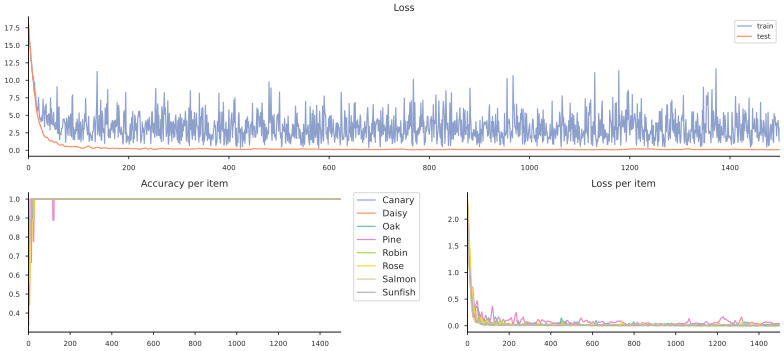

In [13]:
metrics = train_model(
    model := AutoEncoder(sizes=[dataloader.dataset.NUM_ATTRIBUTES, 32], batch_norm=False, dropout=0),
    optimizer := torch.optim.AdamW(model.parameters(), lr=1e-2),
    loss_fn := torch.nn.MSELoss(reduction="sum"),
    dataloader,
    epochs=1500,
    noise_mean=0,
    noise_stdev=1,
    noise_multiplier=0.5,
    l1_lambda=0.0005,
)

plot_metrics(metrics);

In [2]:
from _work.src.modules.utils import round_tensor
from torch.autograd.functional import jacobian

@torch.no_grad()
def get_fixed_points(model, initial_state_fn=None, n_runs=500, n_steps=100, min_occurrence=1, return_counts=False):
    model.eval()

    fixed_points = []
    for _ in range(n_runs):
        x = torch.randn(9) if initial_state_fn is None else initial_state_fn()
        for _ in range(n_steps):
            y = model(x)
            if torch.allclose(x, y):
                fixed_points.append(x)
                break
            x = y
    
    fixed_points = torch.vstack(fixed_points)
    uniqs, indices, counts = torch.unique(
        round_tensor(fixed_points, decimals=3),
        dim=0,
        return_inverse=True,
        return_counts=True,
    )
    t = [[] for _ in indices.unique()]
    for i, j in enumerate(indices):
        t[j].append(fixed_points[i])
    t = [torch.vstack(x).mean(dim=0) for x in t]
    
    mask = counts > min_occurrence
    counts = counts[mask, ...]
    points = torch.vstack(t)[mask, ...]
    sorted_points = torch.vstack([x for _, x in sorted(zip(counts, points), key=lambda x: x[0], reverse=True)])

    if return_counts is True:
        return sorted_points, [x.item() for x in sorted(counts, reverse=True)]
    
    return sorted_points

def is_attractor(model, fixed_point):
    model.eval()

    is_fixed_point = torch.allclose(model(fixed_point), fixed_point, atol=0.05)
    assert is_fixed_point

    def f(*args):
        return model(torch.vstack(args))
    
    j = jacobian(f, fixed_point)
    m = j.abs().max()
    return m.item()
    return (m < 1).item()

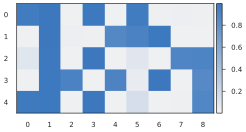

In [102]:
plot_tensor(get_fixed_points(model, n_runs=1000, n_steps=20));

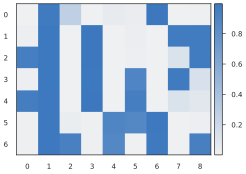

In [165]:
plot_tensor(get_fixed_points(model, n_runs=1000, n_steps=100));

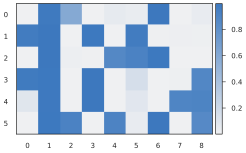

In [103]:
plot_tensor(get_fixed_points(model, n_runs=1000, n_steps=500));

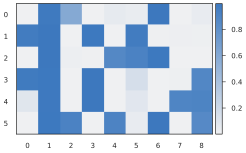

In [104]:
plot_tensor(get_fixed_points(model, n_runs=1000, n_steps=1000));

In [109]:
for pt in get_fixed_points(model, n_runs=1000, n_steps=1000):
    print(is_attractor(model, pt))

0.7618996500968933
0.09708412736654282
0.2738589644432068
0.3265753984451294
0.2437632828950882
0.3182874917984009


In [15]:
patterns = generate_patterns(
    model,
    n_runs=5000,
    n_steps=20,
    take_last=2,
    mean=None,
    stdev=None,
    multiplier=None,
)

noisy_patterns = generate_patterns(
    model,
    n_runs=5000,
    n_steps=20,
    take_last=2,
    mean=0,
    stdev=1,
    multiplier=0.5,
)

KeyboardInterrupt: 

In [3]:
def cl(ps):
    counts = { k: 0 for k in dataloader.dataset.df.index }
    for p in ps:
        (item, dist), *_ = get_distances(p, dataloader.dataset.df, metric='euclidean')
        counts[item] += 1
    return counts

In [79]:
pc = cl(patterns)
npc = cl(noisy_patterns)

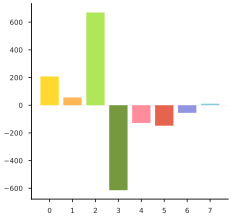

In [118]:
diff = { k: pc[k] - npc[k] for k, v in pc.items() }

with plt.style.context({ 'axes.xmargin': 0.05 }):
    ax = plt.subplot()

    plt.bar(range(8), diff.values(), color=[palette[x] for x in dataloader.dataset.df.index])
    ax.axhline(0, color='0.6', linewidth=0.1)

In [8]:
p_counts = { k: [] for k in dataloader.dataset.df.index }
np_counts = { k: [] for k in dataloader.dataset.df.index }

for _ in range(25):
    metrics = train_model(
        model := AutoEncoder(sizes=[dataloader.dataset.NUM_ATTRIBUTES, 2], batch_norm=False, dropout=0),
        optimizer := torch.optim.AdamW(model.parameters(), lr=1e-2),
        loss_fn := torch.nn.MSELoss(reduction="sum"),
        dataloader,
        epochs=2000,
        noise_mean=0,
        noise_stdev=1,
        noise_multiplier=0.5,
        l1_lambda=0.0005,
    )

    patterns = generate_patterns(
        model,
        n_runs=5000,
        n_steps=20,
        take_last=5,
        mean=None,
        stdev=None,
        multiplier=None,
    )

    noisy_patterns = generate_patterns(
        model,
        n_runs=5000,
        n_steps=20,
        take_last=5,
        mean=0,
        stdev=1,
        multiplier=1,
    )

    pcounts = { k: 0 for k in dataloader.dataset.df.index }
    for p in patterns:
        (item, dist), *_ = get_distances(p, dataloader.dataset.df, metric='euclidean')
        pcounts[item] += 1
    npcounts = { k: 0 for k in dataloader.dataset.df.index }
    for p in noisy_patterns:
        (item, dist), *_ = get_distances(p, dataloader.dataset.df, metric='euclidean')
        npcounts[item] += 1
    for k, v in pcounts.items():
        p_counts[k].append(v)
    for k, v in npcounts.items():
        np_counts[k].append(v)

In [9]:
p_means = { k: np.mean(v) for k, v in p_counts.items() }
np_means = { k: np.mean(v) for k, v in np_counts.items() }

diff = { k: p_means[k] - np_means[k] for k, v in np_means.items() }

# with plt.style.context({ 'axes.xmargin': 0.05 }):
#     ax = plt.subplot()

#     plt.bar(range(8), diff.values(), color=[palette[x] for x in dataloader.dataset.df.index])
#     plt.xticks(ticks=range(8), labels=list(dataloader.dataset.df.index), rotation=-45)
#     ax.axhline(0, color='0.6', linewidth=0.1)

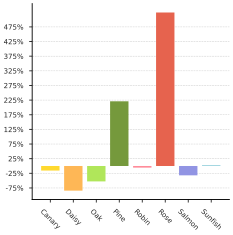

In [11]:
pdiff = { k: (np_means[k]/p_means[k] - 1)*100 for k, v in np_means.items() }

with plt.style.context({ 'axes.xmargin': 0.05 }):
    ax = plt.subplot()

    plt.bar(range(8), pdiff.values(), color=[palette[x] for x in dataloader.dataset.df.index])
    plt.xticks(ticks=range(8), labels=list(dataloader.dataset.df.index), rotation=-45)
    yticks = range(-75, 500, 50)
    plt.yticks(ticks=yticks, labels=[f"{x}%" for x in yticks])
    plt.grid(axis='y', linestyle='--')
    plt.savefig('../plots/2relative_increase_avg_over_25_1_under_2_over')
    # ax.axhline(0, color='0.6', linewidth=0.1)

In [16]:
from sklearn.decomposition import PCA

patterns = generate_patterns(
    model,
    n_runs=5000,
    n_steps=20,
    take_last=5,
    mean=None,
    stdev=None,
    multiplier=None,
)

noisy_patterns = generate_patterns(
    model,
    n_runs=5000,
    n_steps=20,
    take_last=5,
    mean=0,
    stdev=0.5,
    multiplier=1,
)

pca = PCA(n_components=2)
pca.fit(torch.cat((patterns, noisy_patterns), dim=0))

Xp = pca.transform(patterns)
Xnp = pca.transform(noisy_patterns)

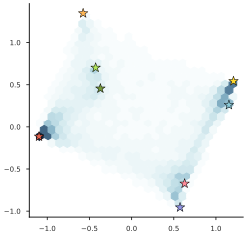

In [22]:
@plt.style.context({"axes.xmargin": 0.05})
def plot_heatmap(x):
    attractors = pca.transform(dataloader.dataset.df)
    # cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    cmap = sns.cubehelix_palette(start=2.8, rot=-.1, light=1, as_cmap=True)

    ax = plt.subplot()
    ax.set_aspect('equal', adjustable='box')
    plt.hexbin(x[:, 0], x[:, 1], gridsize=25, bins=50, cmap=cmap)
    plt.scatter(
        attractors[:, 0],
        attractors[:, 1],
        c=[palette[x] for x in dataloader.dataset.df.index],
        marker="*",
        edgecolors="black",
        s=100,
        linewidths=0.5,
        alpha=1,
    )
    # plt.xlim([-1.4, 1.4])
    # plt.ylim([-1, 1.4]!)
    
    plt.tight_layout()

plot_heatmap(Xnp)

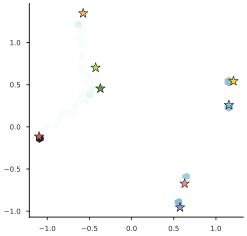

In [23]:
plot_heatmap(Xp)

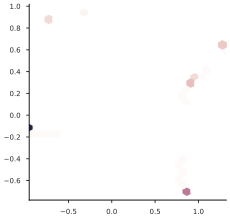

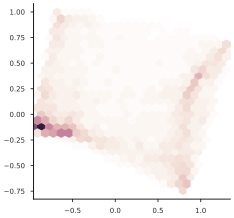

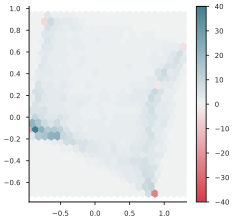

In [61]:
cmap = sns.diverging_palette(10, 220, center='light', as_cmap=True)

hex1 = plt.hexbin(Xp[:, 0], Xp[:, 1], gridsize=25, bins=50, cmap=sns.cubehelix_palette(light=1, as_cmap=True))
plt.show()

hex2 = plt.hexbin(Xnp[:, 0], Xnp[:, 1], gridsize=25, bins=50, cmap=sns.cubehelix_palette(light=1, as_cmap=True))
plt.show()

A = hex2.get_array() - hex1.get_array()
h3 = plt.hexbin(Xp[:, 0], Xp[:, 1], gridsize=25, bins=50, cmap=cmap, vmin=-40, vmax=40)
h3.set_array(A)
plt.colorbar()